In [11]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib
import sys
sys.path.append('./src')
from utils import deserialize_data
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json

In [12]:
X_train_ros = deserialize_data('data/processed/X_train_ros.pkl')
y_train_ros = deserialize_data('data/processed/y_train_ros.pkl')

In [13]:
param_grid_randomforest = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

param_grid_adaboost = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1]
}

param_grid_logisticregression = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}


In [14]:
models = {
    'LogisticRegression': LogisticRegression(n_jobs=-1,solver='liblinear'),
    'RandomForest': RandomForestClassifier(n_jobs=-1),
    'AdaBoost': AdaBoostClassifier()
}

In [15]:

def train_model(model, param_grid: dict, X_train: pd.DataFrame, y_train: pd.Series) -> tuple:
    """
    Train a machine learning model with hyperparameter tuning.

    Parameters:
    - model: estimator object
        A pre-initialized machine learning model instance to be trained.
    - param_grid: dict
        Dictionary specifying the hyperparameters and the range of values for 
        hyperparameter tuning, structured as {'parameter_name': [list_of_values]}.
    - X_train: pd.DataFrame
        Training data containing feature values, with shape (n_samples, n_features).
    - y_train: pd.Series
        Target values corresponding to each sample in `X_train`, with shape (n_samples,).

    Returns:
    - tuple: (best_model, grid_search)
        A tuple containing the best model instance after tuning and the full 
        GridSearchCV object, with the model fitted on `X_train` and `y_train`.
    """
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, verbose=3)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search



In [16]:
trained_models = {}

for model_name, model in models.items():
    param_grid = locals()[f'param_grid_{model_name.lower()}']
    print(f"Training {model_name}...")
    best_model = train_model(model, param_grid, X_train_ros, y_train_ros)
    trained_models[model_name] = best_model
    joblib.dump(best_model, f'models/{model_name}.pkl')


Training LogisticRegression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


d:\software\New folder\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


Training RandomForest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training AdaBoost...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


d:\software\New folder\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [17]:
X_valid = joblib.load('data/processed/X_valid_prep.pkl')
y_valid = joblib.load('data/interim/y_valid.pkl')

def threshold_tuning(model, X_val: pd.DataFrame, y_val: pd.Series, metric: str) -> list:
    """
    Tune the classification threshold for a model to optimize a specified metric.

    Parameters:
    - model: estimator object
        A trained classification model that has a `predict_proba` method.
    - X_val: pd.DataFrame
        Validation feature data for evaluating the model, with shape (n_samples, n_features).
    - y_val: pd.Series
        True labels for the validation data, with shape (n_samples,).
    - metric: str
        Metric to be optimized, as specified in the classification report (e.g., 'f1-score').

    Returns:
    - list: List of dictionaries containing threshold tuning results
        Each dictionary contains:
        - 'model': estimator object
            The model instance used for prediction.
        - 'threshold': float
            Threshold used for converting predicted probabilities into binary predictions.
        - 'metric_value': float
            Calculated metric value (e.g., f1-score) at the given threshold.
    """
    y_prob = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0, 1, 100)
    threshold_results = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_prob >= thresh).astype(int)
        report = classification_report(y_val, y_pred_thresh, output_dict=True)
        metric_value = report['macro avg'][metric]
        threshold_results.append({
            'model': model,
            'threshold': thresh,
            'metric_value': metric_value
        })
    
    return threshold_results



In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics_vs_threshold(threshold_results, metric):
    thresholds = [res['threshold'] for res in threshold_results]
    metric_values = [res['metric_value'] for res in threshold_results]
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=thresholds, y=metric_values)
    plt.title(f"{metric} vs Threshold")
    plt.xlabel('Threshold')
    plt.ylabel(metric)
    plt.show()


Tuning threshold for LogisticRegression...


d:\software\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\software\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\software\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\software\New folder\Lib\site-packages\sklea

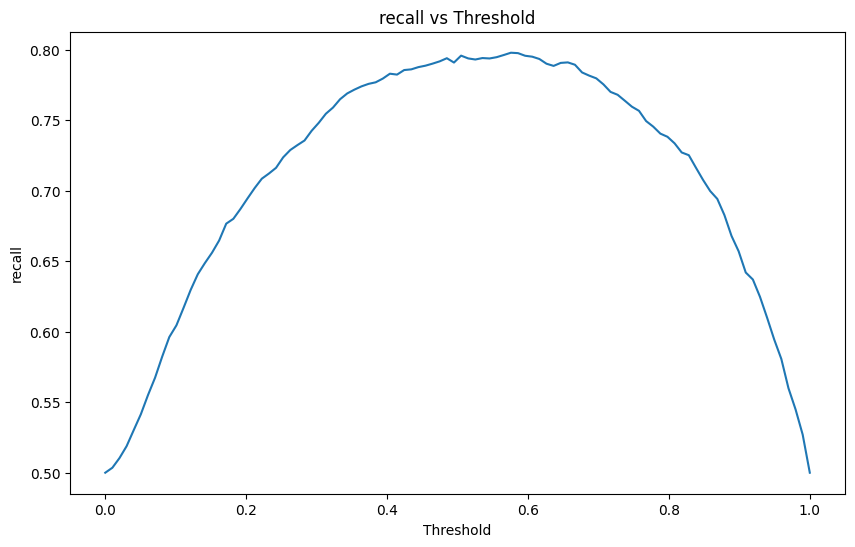

d:\software\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Tuning threshold for RandomForest...


d:\software\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\software\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


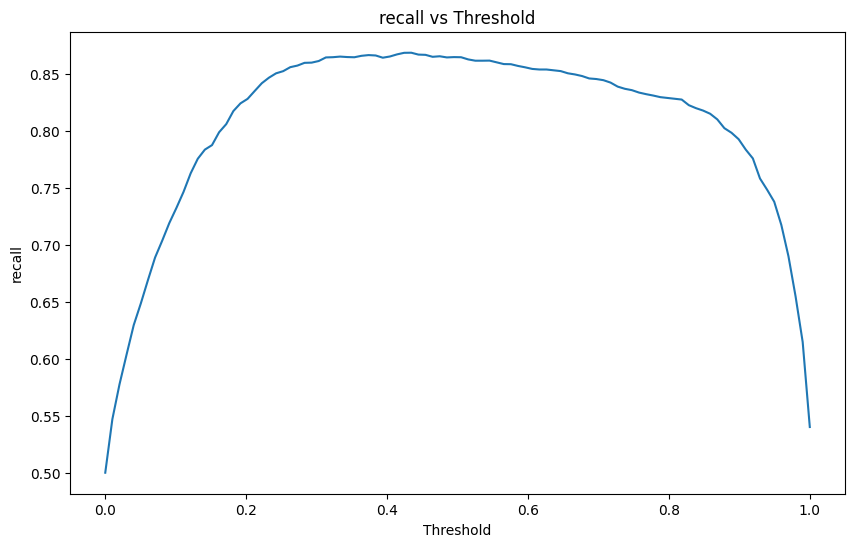

Tuning threshold for AdaBoost...


d:\software\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\software\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\software\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\software\New folder\Lib\site-packages\sklea

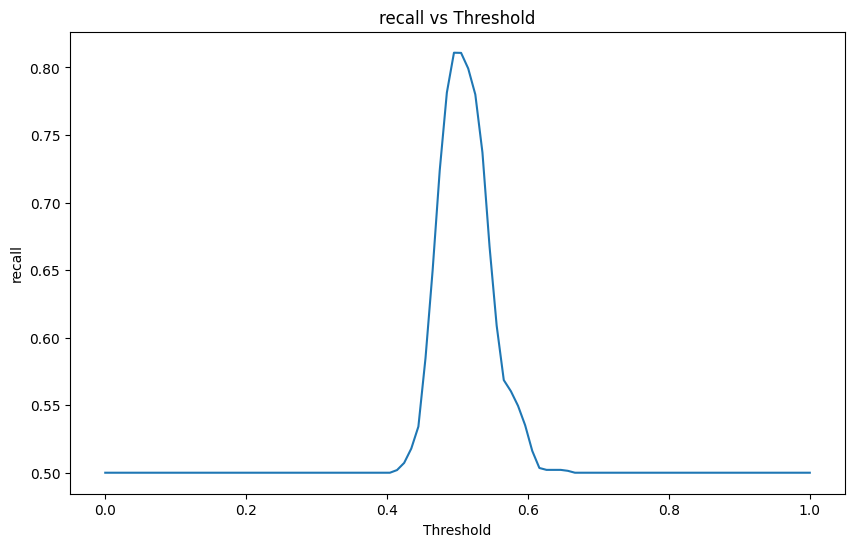

In [19]:
all_thresholds = {}

for model_name, model_data in trained_models.items():
    model = model_data[0] if isinstance(model_data, tuple) else model_data
    if hasattr(model, 'predict_proba'):
        print(f"Tuning threshold for {model_name}...")
        threshold_results = threshold_tuning(model, X_valid, y_valid, 'recall')
        all_thresholds[model_name] = threshold_results
        plot_metrics_vs_threshold(threshold_results, 'recall')
    else:
        print(f"{model_name} does not support probability prediction.")


In [20]:
import pandas as pd

def select_best_threshold(all_thresholds: dict) -> dict:
    """
    Select the best threshold for each model based on a specified metric value.

    Parameters:
    - all_thresholds: dict
        Dictionary where keys are model names and values are lists of dictionaries, 
        each containing 'threshold' and 'metric_value' for different threshold values.

    Returns:
    - dict: Dictionary containing the best model, its optimal threshold, 
            and the corresponding metric value, saved to 'best_threshold.json'.
        - 'model': str
            Name of the model with the highest metric value.
        - 'threshold': float
            Optimal threshold value for this model.
        - 'metric_value': float
            Highest metric value for the selected threshold.
    """
    all_results = []
    
    for model_name, threshold_list in all_thresholds.items():
        for result in threshold_list:
            all_results.append({
                'model': model_name,
                'threshold': result['threshold'],
                'metric_value': result['metric_value']
            })
    
    df_results = pd.DataFrame(all_results)
    df_results = df_results.sort_values(by='metric_value', ascending=False)
    
    best_result = df_results.iloc[0]
    best_threshold = {
        'model': best_result['model'],
        'threshold': best_result['threshold'],
        'metric_value': best_result['metric_value']
    }
    
    best_threshold_path = 'best_threshold.json'
    with open(best_threshold_path, 'w') as f:
        json.dump(best_threshold, f)
    
    return best_threshold



In [21]:
def evaluate_model(model, best_threshold: float, X_test: pd.DataFrame, y_test: pd.Series) -> None:
    """
    Evaluate a trained model on test data using a specified threshold.

    Parameters:
    - model: estimator object
        A trained classification model with a `predict_proba` method.
    - best_threshold: float
        Threshold for converting predicted probabilities into binary predictions.
    - X_test: pd.DataFrame
        Test data containing feature values, with shape (n_samples, n_features).
    - y_test: pd.Series
        True labels for the test data, with shape (n_samples,).

    Returns:
    - None
        Prints the classification report showing performance metrics (e.g., precision, recall, F1-score).
    """
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred_thresh = (y_prob >= best_threshold).astype(int)
    print(classification_report(y_test, y_pred_thresh))


In [23]:
X_test = joblib.load('data/processed/X_test_prep.pkl')
y_test = joblib.load('data/interim/y_test.pkl')

best_threshold = select_best_threshold(all_thresholds)
best_model = trained_models[best_threshold['model']][0] if isinstance(trained_models[best_threshold['model']], tuple) else trained_models[best_threshold['model']]
evaluate_model(best_model, best_threshold['threshold'], X_test, y_test)


              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2548
           1       0.89      0.73      0.80       711

    accuracy                           0.92      3259
   macro avg       0.91      0.85      0.88      3259
weighted avg       0.92      0.92      0.92      3259

